## ETL in Python
---

## Ciencia de los Datos Aplicada
* ##### Facultad de Minas
* ##### Universidad Nacional de Colombia
* ##### Autor: Valentina Vásquez Hernandez

---

### 1. Definición del problema en términos del negocio

Los archivos `Traditional_exports_<year>` corresponden a las exportaciones colombianas de café, carbón, ferroníquel y petróleo y sus derivados, denominados como tradicionales, y que representan aproximadamente el 62% de las exportaciones totales del país.[1]
.
Se encuentran medidas en toneladas métricas (volumen de producto en medida internacional) y en dolares FOB (Free On Board) que denota el valor de los productos en las aduanas fronterizas incluyendo el costo de impuestos, derechos de exportación, inspecciones, etc, hasta que este ha sido debidamente puesto en el transporte de salida.

In [17]:
! head data/input/Traditional_exports_2013.csv

date;unit_measure;coffee;coal;oil_oilbyproducts;ferronickel 
1/01/2013;USDkFOB;198__825;331.415;869.485;164.672
1/02/2013;USDkFOB;204--067;320.377;798.291;84.737
1/03/2013;USDkFOB;185[]607;451.517;1.018.803;NA  
1/04/2013;USDkFOB;166::088;505.207;1.008.097;106.612
1/05/2013;USDkFOB;147[]223;443.903;1.202.917;59.587
1/06/2013;USDkFOB;159-_400;526.593;1.460.899;115.974
1/07/2013;USDkFOB;172-_324;512.079;1.335.526;104.470
1/08/2013;USDkFOB;116[]587;388.721;1.274.605;59.520
1/09/2013;USDkFOB;129--225;416.759;1.208.662;34.901


### 2. Definición del problema en términos de los datos

El objetivo de este taller es construir el pipeline de una ETL (Extract, Transform and Load) en Python usando PSL para el procesamiento de los datos y Pandas para obtener métricas básicas y disponibilizar el esquema resultante. A continuación un paso a paso para lograr este objetivo:

In [18]:
print("Hola")

Hola


> `Paso 1: Extract:` Tomar los archivos *Traditional_exports_year*, unificar el formato de las columnas y exportar el resultado a un archivo csv unificado para todos los años.

        1. Formatear la fecha a YYYY-MM-dd 
        2. Unificar las unidades de medida
        3. Unificar el separador de miles 

> `Paso 2: Transform:` Generar las siguientes transformaciones en los datos de acuerdo con el archivo obtenido en el paso anterior:

        1. Eliminar registros con registros nulos
        2. Obtener al total de exportaciones por año y por unidad de medida
        3. Obtener el valor mínimo, máximo y promedio de cada tipo de exportación por año y unidad de medida
        4. Obtener gráfica donde se observe la evolución del FOB USD en los años por commodity
        5. Obtener gráfica donde se observe el cambio en la composición de las exportaciones por commodity

> `Paso 3: Load:` 

        1. Exportar la tabla obtenida en el numeral 2 del paso anterior a formato .csv, .parquet y .json

### Paso 1. Extract

In [19]:
## Se importan las librerías necesarias
import glob
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
## Se muestran los archivos con el patrón de nombre
files = glob.glob('data/input/Traditional_*.csv')
files

['data/input/Traditional_exports_2017.csv',
 'data/input/Traditional_exports_2016.csv',
 'data/input/Traditional_exports_2014.csv',
 'data/input/Traditional_exports_2015.csv',
 'data/input/Traditional_exports_2013.csv',
 'data/input/Traditional_exports_2018.csv']

In [21]:
! head data/input/Traditional_exports_2013.csv

date;unit_measure;coffee;coal;oil_oilbyproducts;ferronickel 
1/01/2013;USDkFOB;198__825;331.415;869.485;164.672
1/02/2013;USDkFOB;204--067;320.377;798.291;84.737
1/03/2013;USDkFOB;185[]607;451.517;1.018.803;NA  
1/04/2013;USDkFOB;166::088;505.207;1.008.097;106.612
1/05/2013;USDkFOB;147[]223;443.903;1.202.917;59.587
1/06/2013;USDkFOB;159-_400;526.593;1.460.899;115.974
1/07/2013;USDkFOB;172-_324;512.079;1.335.526;104.470
1/08/2013;USDkFOB;116[]587;388.721;1.274.605;59.520
1/09/2013;USDkFOB;129--225;416.759;1.208.662;34.901


In [22]:
iter_file = "data/input/Traditional_exports_2013.csv"
file = open(iter_file, 'r').readlines()
file

['date;unit_measure;coffee;coal;oil_oilbyproducts;ferronickel \n',
 '1/01/2013;USDkFOB;198__825;331.415;869.485;164.672\n',
 '1/02/2013;USDkFOB;204--067;320.377;798.291;84.737\n',
 '1/03/2013;USDkFOB;185[]607;451.517;1.018.803;NA  \n',
 '1/04/2013;USDkFOB;166::088;505.207;1.008.097;106.612\n',
 '1/05/2013;USDkFOB;147[]223;443.903;1.202.917;59.587\n',
 '1/06/2013;USDkFOB;159-_400;526.593;1.460.899;115.974\n',
 '1/07/2013;USDkFOB;172-_324;512.079;1.335.526;104.470\n',
 '1/08/2013;USDkFOB;116[]587;388.721;1.274.605;59.520\n',
 '1/09/2013;USDkFOB;129--225;416.759;1.208.662;34.901\n',
 '1/10/2013;USDkFOB;128__630;372.998;899.103;0\n',
 '1/11/2013;USDkFOB;99::066;119.325;647.674;13.064\n',
 '1/12/2013;USDkFOB;147&&924;123.714;486.439;34.677\n',
 '1/01/2013;MetricTons;66[]969;5.680.613;1.629.315;17.404\n',
 '1/02/2013;MetricTons;67&&361;4.652.213;1.398.563;9.584\n',
 '1/03/2013;MetricTons;57::227;6.990.127;1.646.669;NA  \n',
 '1/04/2013;MetricTons;50-_740;7.198.798;1.608.215;11.157\n',
 '1/05

In [23]:
date  = re.search('^([0-9]+)/([0-9]+)/([0-9]+);([a-zA-Z]+);', file[1])
date

<re.Match object; span=(0, 18), match='1/01/2013;USDkFOB;'>

In [24]:
date.group(3) + '-'  + date.group(2) + '-' + '0' + date.group(1)  + ';'  + date.group(4) + ';'

'2013-01-01;USDkFOB;'

In [25]:
numbers = re.search(';([0-9]+)([!#$%&*+-.^_`|~:\[\]]+)([0-9]+);([0-9]+[.,-;=:%&]+[0-9]+);([0-9]+[.,-;=:%&]+[0-9]+;.+)', file[1])
numbers.group(1) + '.'  + numbers.group(3) + ";" + numbers.group(4) + ";" + numbers.group(5)

'198.825;331.415;869.485;164.672'

In [26]:
##Antes
file[1]

'1/01/2013;USDkFOB;198__825;331.415;869.485;164.672\n'

In [27]:
def render_line(line):
    """
    Gets traditional_exports_<year> format line
    Input: string
    Output: string
    """
    try: 
        date  = re.search('^([0-9]+)/([0-9]+)/([0-9]+);([a-zA-Z]+);', line)
        date_string = date.group(3) + '-'  + date.group(2) + '-' + '0' + date.group(1)  + ';'  + date.group(4) + ';'
        numbers = re.search(';([0-9]+)([!#$%&*+-.^_`|~:\[\]]+)([0-9]+);([0-9]+[.,-;=:%&]+[0-9]+);([0-9]+[.,-;=:%&]+[0-9]+;.+)', line)
        numbers_string = numbers.group(1) + '.'  + numbers.group(3) + ";" + numbers.group(4) + ";" + numbers.group(5)
        return date_string + numbers_string + '\n'
    except: 
        print("Format error. Check Regex")

In [28]:
file_new = open('data/output/Exports_2013_2018.csv', 'w')
file_new.write("date;unit_measure;coffee;coal;oil_oilbyproducts;ferronickel\n")

for iter_file in files: 
    file = open(iter_file, 'r').readlines()
    
    for line in file[1:]:
        if render_line(line): 
            file_new.write(render_line(line))
        else: print(line)
file_new.close()

### Paso 2. Transform

In [29]:
## Se leen los registros del archivo generado en el paso anterior
df_exports = pd.read_csv('data/output/Exports_2013_2018.csv', sep = ';', thousands = '.', na_values=['NA  ','NA   '])  
df_exports.head()

,date,unit_measure,coffee,coal,oil_oilbyproducts,ferronickel
0,2017-01-01,USDkFOB,227674,426885,1179658,14728.0
1,2017-02-01,USDkFOB,210303,498033,919528,437.0
2,2017-03-01,USDkFOB,286062,616233,1040526,30851.0
3,2017-04-01,USDkFOB,209099,385891,1063556,4459.0
4,2017-05-01,USDkFOB,187682,804563,1075943,62508.0


In [30]:
## Se obtienen los tipos de dato. 
# La columna date se importa automáticamente como string. Es necesario cambiarla para acceder a las funciones datetime
df_exports.dtypes

date                  object
unit_measure          object
coffee                 int64
coal                   int64
oil_oilbyproducts      int64
ferronickel          float64
dtype: object

In [31]:
## Se convierte la fecha a formato correcto
df_exports['date'] = pd.to_datetime(df_exports['date'])

In [32]:
## Obtener columna de año
df_exports['year'] = df_exports['date'].dt.year
df_exports.dtypes

date                 datetime64[ns]
unit_measure                 object
coffee                        int64
coal                          int64
oil_oilbyproducts             int64
ferronickel                 float64
year                          int64
dtype: object

In [33]:
df_exports.head()

,date,unit_measure,coffee,coal,oil_oilbyproducts,ferronickel,year
0,2017-01-01,USDkFOB,227674,426885,1179658,14728.0,2017
1,2017-02-01,USDkFOB,210303,498033,919528,437.0,2017
2,2017-03-01,USDkFOB,286062,616233,1040526,30851.0,2017
3,2017-04-01,USDkFOB,209099,385891,1063556,4459.0,2017
4,2017-05-01,USDkFOB,187682,804563,1075943,62508.0,2017


In [34]:
## Se obtienen métricas descriptivas de cada una de las varaibles numéricas 
df_exports.describe()

,coffee,coal,oil_oilbyproducts,ferronickel,year
count,134.000000,1.340000e+02,1.340000e+02,128.000000,134.000000
mean,125784.671642,3.734873e+06,2.337259e+06,26861.765625,2015.313433
std,78581.637912,3.686308e+06,1.245713e+06,26474.068706,1.628773
min,33184.000000,1.193250e+05,4.864390e+05,0.000000,2013.000000
25%,55211.500000,4.330085e+05,1.144272e+06,9980.250000,2014.000000
50%,106228.500000,1.121291e+06,2.001843e+06,14472.000000,2015.000000
75%,192170.000000,6.554646e+06,3.505635e+06,36545.750000,2017.000000
max,424028.000000,1.473690e+07,4.593090e+06,164672.000000,2018.000000


In [35]:
## se eliminan las columnas que tengan por lo menos un null
df_exports.dropna(axis='columns').columns

Index(['date', 'unit_measure', 'coffee', 'coal', 'oil_oilbyproducts', 'year'], dtype='object')

In [36]:
len(df_exports)

134

In [37]:
len(df_exports)

134

In [38]:
## Se eliminan las filas que tengan por lo menos un null 
df_exports.dropna(thresh=len(df_exports.columns), inplace=True)

In [39]:
## Se obtiene el total de exportaciones por año y medida
df_exports_year = df_exports.groupby(['unit_measure', 'year']).sum()
df_exports_year

coffee       coal  oil_oilbyproducts  ferronickel
unit_measure year                                                    
MetricTons   2013   529806   52675813           19721265      94999.0
             2014   617959   89095315           49142512     132555.0
             2015   711111   74711449           48431826     128634.0
             2016   732967   85127799           43935044     127742.0
             2017   710355  105235590           40029965     110957.0
             2018   347495   47712693           18711895      80686.0
USDkFOB      2013  1669359    4061091           11191698     778214.0
             2014  2076375    5681096           24757038     527796.0
             2015  2526532    4560026           14566130     429752.0
             2016  2417693    4638881           10795579     327765.0
             2017  2513503    7389996           13166719     360543.0
             2018  1125071    3961935            8157412     338663.0

In [40]:
## Se obtienen el minimo, max y media por cada año y unidad de medida
df_exports.loc[:, 'unit_measure':'year'].groupby(['unit_measure', 'year']).agg(['min', 'max', 'mean'])

coffee                            coal            \
                      min     max           mean      min       max   
unit_measure year                                                     
MetricTons   2013   33184   67361   48164.181818  1079153   7198798   
             2014   36257   66993   51496.583333  3331867  12456190   
             2015   44691   75227   59259.250000  4798950   7605814   
             2016   39095  113391   61080.583333  4563426  11912907   
             2017   37825   77088   59196.250000  4975521  14736902   
             2018   44127   74254   57915.833333  5970972   9579831   
USDkFOB      2013   99066  204067  151759.909091   119325    526593   
             2014  139214  261195  207637.500000   268100    977542   
             2015  155986  282199  210544.333333   275602    498557   
             2016  126356  424028  201474.416667   235075    654162   
             2017  132054  286062  209458.583333   359358   1163429   
             2018  141569  247016  187511.833333   493301    806803   

                                oil_oilbyproducts                         \
                           mean               min      max          mean   
unit_measure year                                                          
MetricTons   2013  4.788710e+06           1398563  2095938  1.792842e+06   
             2014  7.424610e+06           3653691  4442970  4.095209e+06   
             2015  6.225954e+06           3492278  4593090  4.035986e+06   
             2016  7.093983e+06           3350926  4099192  3.661254e+06   
             2017  8.769632e+06           2836185  3655405  3.335830e+06   
             2018  7.952116e+06           2958676  3258040  3.118649e+06   
USDkFOB      2013  3.691901e+05            486439  1460899  1.017427e+06   
             2014  5.681096e+05           1836360  2791267  2.475704e+06   
             2015  3.800022e+05            816748  1637327  1.213844e+06   
             2016  3.865734e+05            655691  1087928  8.996316e+05   
             2017  6.158330e+05            919528  1397578  1.097227e+06   
             2018  6.603225e+05           1194653  1469748  1.359569e+06   

                  ferronickel                          
                          min       max          mean  
unit_measure year                                      
MetricTons   2013         0.0   17404.0   8636.272727  
             2014      7278.0   13661.0  11046.250000  
             2015      3696.0   20316.0  10719.500000  
             2016      5410.0   15419.0  10645.166667  
             2017       332.0   21729.0   9246.416667  
             2018     10589.0   16077.0  13447.666667  
USDkFOB      2013         0.0  164672.0  70746.727273  
             2014     32959.0   73247.0  52779.600000  
             2015     15959.0   80976.0  35812.666667  
             2016     13869.0   36804.0  27313.750000  
             2017       437.0   63931.0  30045.250000  
             2018     42839.0   70482.0  56443.833333

### pandas.pivot
<img src="data/pivot.png" alt="drawing" width="600"/>

In [41]:
## Se toma los datos del año 2017
df_pivot = df_exports[(df_exports['year'] ==  2017)]

In [42]:
## Transpose
df_pivot.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,...,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00
unit_measure,USDkFOB,USDkFOB,USDkFOB,USDkFOB,USDkFOB,USDkFOB,USDkFOB,USDkFOB,USDkFOB,USDkFOB,...,MetricTons,MetricTons,MetricTons,MetricTons,MetricTons,MetricTons,MetricTons,MetricTons,MetricTons,MetricTons
coffee,227674,210303,286062,209099,187682,132054,224406,202233,233587,209842,...,77088,57973,52450,37825,66120,59373,66721,59872,56936,58920
coal,426885,498033,616233,385891,804563,359358,652621,560126,834211,554439,...,8683657,5603903,12455878,4975521,10159976,8747276,12246021,7834836,6888399,14736902
oil_oilbyproducts,1179658,919528,1040526,1063556,1075943,1042656,978907,1078869,1042128,1236888,...,3297163,3351406,3390710,3604211,3271744,3441527,3118191,3445708,3025842,3591873
ferronickel,14728.0,437.0,30851.0,4459.0,62508.0,26292.0,5929.0,63931.0,25659.0,44222.0,...,9592.0,1693.0,19861.0,8423.0,2030.0,21729.0,8165.0,11846.0,13947.0,9021.0
year,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,...,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017


In [43]:
## Pivoter la tabla de acuerdo a un index
df_pivot.pivot(index='date', columns = 'unit_measure', values = 'coal')

unit_measure,MetricTons,USDkFOB
date,,
2017-01-01,6516997,426885
2017-02-01,6386224,498033
2017-03-01,8683657,616233
2017-04-01,5603903,385891
2017-05-01,12455878,804563
2017-06-01,4975521,359358
2017-07-01,10159976,652621
2017-08-01,8747276,560126
2017-09-01,12246021,834211


### pandas.melt
<img src="data/melt.png" alt="drawing" width="600"/>

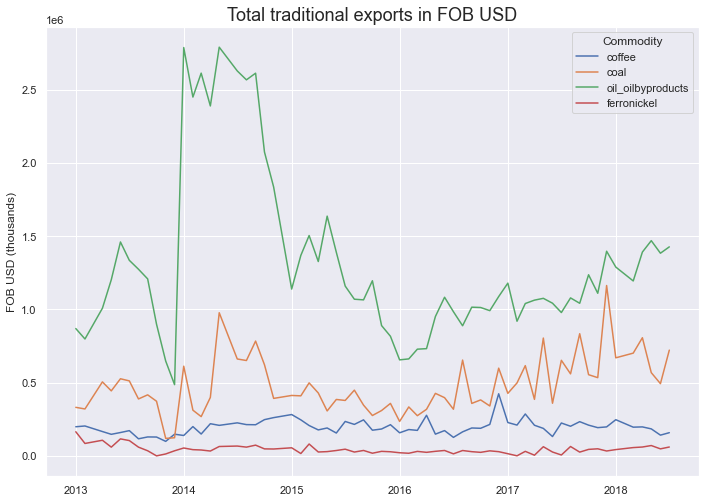

In [44]:
## Se obtiene la gráfica donde se observe la evolución del FOB USD en los años por commodity
sns.set(rc={'figure.figsize':(11.7,8.27)})
pre_aux = df_exports[(df_exports['unit_measure'] ==  'USDkFOB')]
aux = pre_aux.melt(id_vars=['date'], value_vars=['coffee', 'coal','oil_oilbyproducts', 'ferronickel' ])
aux.columns = ['date', 'Commodity', 'value']

sns.set_theme(style="darkgrid")
ax = sns.lineplot(data=aux, x="date", y="value", hue="Commodity")
ax.set_title('Total traditional exports in FOB USD',fontsize=18)
ax.set_ylabel('FOB USD (thousands)');ax.set_xlabel('')
plt.show()

Text(0, 0.5, 'Year')

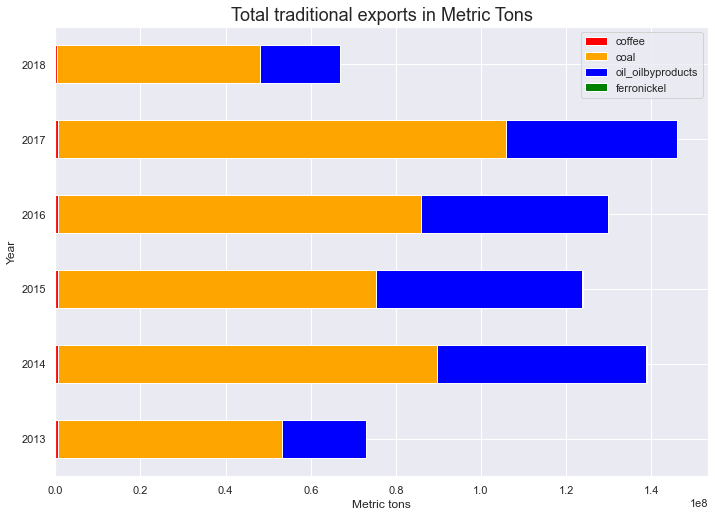

In [45]:
## Se obtiene gráfica donde se observe el cambio en la composición de las exportaciones por commodity
sns.set(rc={'figure.figsize':(11.7,8.27)})
pre_aux = df_exports[(df_exports['unit_measure'] ==  'MetricTons')]
aux = pre_aux.loc[:, 'coffee':'year'].groupby(['year']).sum() 
aux.plot(kind='barh', stacked=True, color=['red', 'orange','blue', 'green'])
 
# Add Title and Labels
plt.title('Total traditional exports in Metric Tons',fontsize=18)
plt.xlabel('Metric tons')
plt.ylabel('Year')

### Paso 3. Load

Se exporta el objeto df_exports_year a formato .csv

In [46]:
df_exports_year.to_csv('data/output/Trad_exports_byyear.csv')

Se exporta el objeto df_exports_year a formato .parquet

In [47]:
df_exports_year.to_parquet('data/output/Trad_exports_byyear.parquet', engine='fastparquet')

ImportError: Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

Se exporta el objeto df_exports_year a formato .json

In [ ]:
df_exports_year.to_json('data/output/Trad_exports_byyear.json', orient="split")

---